In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### A function that reads a sound file, apply Fourier, find peak frequencies and return.


In [3]:
def find_harmonics(path, print_peaks=False):
    fs, X = wavfile.read(path)
    N = len(X)
    X_F = fft(X)
    X_F_onesided = 2.0/N * np.abs(X_F[0:N//2])
    freqs = fftfreq(N, 1/fs)[:N//2]
    freqs_50_index = np.abs(freqs - 50).argmin()
    
    h = X_F_onesided.max()*5/100
    peaks, _ = find_peaks(X_F_onesided, distance=10, height = h)
    peaks = peaks[peaks>freqs_50_index]
    harmonics = np.round(freqs[peaks],2)
    
    if print_peaks:
        i = peaks.max() + 100
        plt.plot(freqs[:i], X_F_onesided[:i])
        plt.plot(freqs[peaks], X_F_onesided[peaks], "x")
        plt.xlabel('Frequency [Hz]')
        plt.show()
    return harmonics

## 2. Import Dataset

In [4]:
path = "drive/MyDrive/Audio_Files"
data = []
max_harm_length = 0 # i will keep track of max harmonic length for naming columns

for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        foldername = os.path.basename(dirname)
        full_path = os.path.join(dirname, filename)
        freq_peaks = find_harmonics(full_path)
        
        max_harm_length = max(max_harm_length, len(freq_peaks))
        
        cur_data = [foldername, filename]
        cur_data.extend([freq_peaks.min(), freq_peaks.max(), len(freq_peaks)])
        cur_data.extend(freq_peaks)
        
        data.append(cur_data)

In [5]:
# Column Names for DataFrame:
cols = ["Chord Type", "File Name", "Min Harmonic", "Max Harmonic", "# of Harmonics"]
for i in range(max_harm_length):
    cols.append("Harmonic {}".format(i+1))

# Creating DataFrame
df = pd.DataFrame(data, columns=cols)
df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Harmonic 29,Harmonic 30,Harmonic 31,Harmonic 32,Harmonic 33,Harmonic 34,Harmonic 35,Harmonic 36,Harmonic 37,Harmonic 38
0,Minor,Minor_0.wav,130.67,2102.22,23,130.67,196.00,261.78,312.00,392.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Minor,Minor_10.wav,138.70,2492.63,33,138.70,208.70,262.18,277.83,329.57,...,2076.98,2102.19,2216.54,2308.72,2492.63,NaN,NaN,NaN,NaN,NaN
2,Minor,Minor_1.wav,131.11,1251.11,14,131.11,196.44,261.78,311.56,387.56,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Minor,Minor_115.wav,86.96,1053.05,18,86.96,155.65,173.48,208.26,233.05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Minor,Minor_158.wav,195.81,1960.00,16,195.81,278.14,392.09,556.28,588.37,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 3. Data Exploration

In [6]:
df["Chord Type"].value_counts()

Major    502
Minor    357
Name: Chord Type, dtype: int64

## 3.2 Number of Harmonics

In [7]:
df["# of Harmonics"].describe()

count    859.000000
mean      20.389988
std        6.656608
min        8.000000
25%       15.000000
50%       20.000000
75%       25.000000
max       38.000000
Name: # of Harmonics, dtype: float64

In [8]:
print("Number of Missing values:")
miss_values = df.isnull().sum().sort_values(ascending=False)
miss_values[miss_values>0]

Number of Missing values:


Harmonic 38    858
Harmonic 37    857
Harmonic 36    855
Harmonic 35    847
Harmonic 34    839
Harmonic 33    829
Harmonic 32    813
Harmonic 31    793
Harmonic 30    773
Harmonic 29    754
Harmonic 28    720
Harmonic 27    682
Harmonic 26    656
Harmonic 25    611
Harmonic 24    551
Harmonic 23    501
Harmonic 22    471
Harmonic 21    438
Harmonic 20    406
Harmonic 19    382
Harmonic 18    345
Harmonic 17    306
Harmonic 16    241
Harmonic 15    191
Harmonic 14    150
Harmonic 13    108
Harmonic 12     74
Harmonic 11     46
Harmonic 10     20
Harmonic 9      10
dtype: int64

## 3.3 Feature Engineering on Harmonics


*   If I divide Harmonic 2 by Harmonic 1, I can obtain the first interval.




In [9]:
df_original = df.copy() # Keeping original of df, I may need later

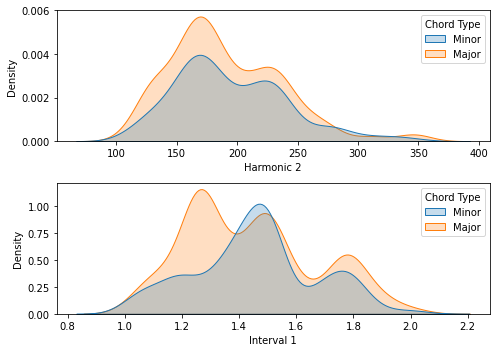

In [10]:
df["Interval 1"] = df["Harmonic 2"].div(df["Harmonic 1"], axis=0)

fig, axes = plt.subplots(2, 1, figsize=(7, 5))
sns.kdeplot(ax=axes[0], data=df, x="Harmonic 2", hue="Chord Type", shade=True)
sns.kdeplot(ax=axes[1], data=df, x="Interval 1", hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

In [11]:
df = df_original.copy() # refreshing df

for i in range(1,21):
    curr_interval = "Interval {}".format(i)
    curr_harm = "Harmonic {}".format(i+1)
    prev_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df[prev_harm], axis=0)

df.head()

,Chord Type,File Name,Min Harmonic,Max Harmonic,# of Harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,...,Interval 11,Interval 12,Interval 13,Interval 14,Interval 15,Interval 16,Interval 17,Interval 18,Interval 19,Interval 20
0,Minor,Minor_0.wav,130.67,2102.22,23,130.67,196.00,261.78,312.00,392.00,...,1.121033,1.121083,1.061178,1.050885,1.048429,1.134687,1.003702,1.005392,1.166709,1.019584
1,Minor,Minor_10.wav,138.70,2492.63,33,138.70,208.70,262.18,277.83,329.57,...,1.053511,1.055406,1.131875,1.054115,1.005241,1.185507,1.054947,1.005836,1.056747,1.124267
2,Minor,Minor_1.wav,131.11,1251.11,14,131.11,196.44,261.78,311.56,387.56,...,1.198639,1.169679,1.361219,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Minor,Minor_115.wav,86.96,1053.05,18,86.96,155.65,173.48,208.26,233.05,...,1.048016,1.069709,1.122901,1.167503,1.020599,1.249828,1.348543,NaN,NaN,NaN
4,Minor,Minor_158.wav,195.81,1960.00,16,195.81,278.14,392.09,556.28,588.37,...,1.126003,1.004154,1.061481,1.167085,1.005489,NaN,NaN,NaN,NaN,NaN


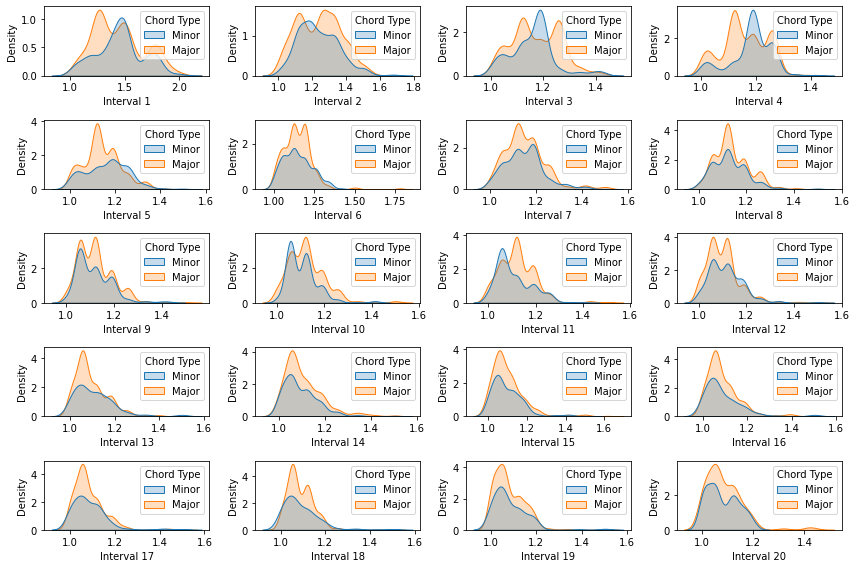

In [12]:
# Lets plot them
fig, axes = plt.subplots(5, 4, figsize=(12, 8))
for i in range(1,21):
    plt.subplot(5, 4, i)
    sns.kdeplot(data=df, x="Interval {}".format(i), hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()

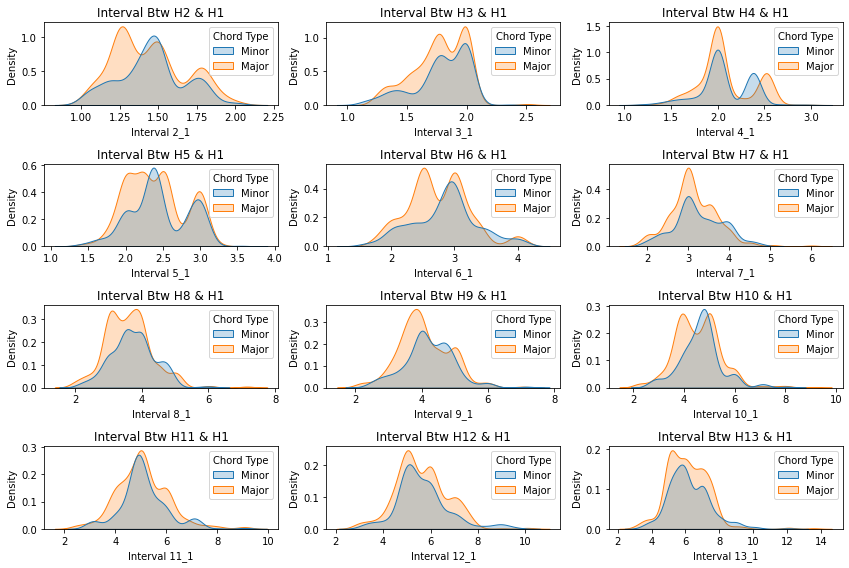

In [13]:
fig, axes = plt.subplots(4, 3, figsize=(12, 8))
for i in range(2,14):
    curr_interval = "Interval {}_1".format(i)
    curr_harm = "Harmonic {}".format(i)
    df[curr_interval] = df[curr_harm].div(df["Harmonic 1"], axis=0)
    
    plt.subplot(4, 3, i-1)
    plt.gca().set_title("Interval Btw H{} & H1".format(i))
    sns.kdeplot(data=df, x=curr_interval, hue="Chord Type", shade=True)
fig.tight_layout()
plt.show()


In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

import matplotlib.pyplot as plt
torch.manual_seed(123123)

In [15]:
df["Chord Type"] = df["Chord Type"].replace("Major", 1)
df["Chord Type"] = df["Chord Type"].replace("Minor", 0)

columns = ["Interval 1", "Interval 2", "Interval 3", "Interval 4"]
columns.extend(["Interval 4_1", "Interval 5_1", "Interval 6_1"])
train_X, val_X, train_y, val_y = train_test_split(df[columns], df["Chord Type"], test_size=0.20, random_state=0)

train_X.head()

,Interval 1,Interval 2,Interval 3,Interval 4,Interval 4_1,Interval 5_1,Interval 6_1
824,1.421060,1.257046,1.119610,1.261579,2.000000,2.523158,2.838987
262,1.788506,1.118216,1.191444,1.258990,2.382810,2.999936,3.577012
624,1.498471,1.058474,1.123816,1.120357,1.782476,1.997009,2.380668
122,1.340093,1.337559,1.119546,1.189841,2.006735,2.387694,2.676819
561,1.055568,1.301432,1.022045,1.018008,1.404034,1.429318,1.770227


In [16]:
class Net(nn.Module):
    def __init__(self, num_pixels, hidden_size):
        super(Net, self).__init__()
        self.RNN = nn.GRU(input_size=num_pixels, hidden_size=hidden_size, batch_first=True)
        self.classifier = nn.Linear(hidden_size, 2)

        for m in self.modules():
          if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')

    def forward(self, x):
        out, hn = self.RNN(x)
        out = self.classifier(out)
        return out

In [17]:
class CHORD_DATA(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

## Make Labels one-hot

In [18]:
train_y_ = train_y.to_numpy().astype(np.float32)
val_y_ = val_y.to_numpy().astype(np.float32)

train_y, val_y = [], []

for y in train_y_:
  if y == 1.0: train_y.append([0.0, 1.0])
  else: train_y.append([1.0, 0.0])

for y in val_y_:
  if y == 1.0: val_y.append([0.0, 1.0])
  else: val_y.append([1.0, 0.0])

In [21]:
train_set = CHORD_DATA(train_X.to_numpy().astype(np.float32), np.array(train_y))
val_set = CHORD_DATA(val_X.to_numpy().astype(np.float32), np.array(val_y))

print("# training data=", len(train_set))
print("# validation data=", len(val_set))

cnt_major, cnt_minor = 0, 0
for y in train_y:
  if y == [0,1]: cnt_major += 1
  else: cnt_minor += 1

print("# major chords in training data=", cnt_major)
print("# minor chords in training data=", cnt_minor)

train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False)

model = Net(num_pixels=7, hidden_size=16)
print(model)
summary(model, input_size=(7,))

# training data= 687
# validation data= 172
# major chords in training data= 400
# minor chords in training data= 287
Net(
  (RNN): GRU(7, 16, batch_first=True)
  (classifier): Linear(in_features=16, out_features=2, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1       [[-1, 16], [-1, 16]]               0
            Linear-2                    [-1, 2]              34
Total params: 34
Trainable params: 34
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [ ]:
loss_func = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

num_epochs = 50

epoch_list = np.arange(num_epochs)
loss_tr_list, loss_val_list = [], []
acc_tr_list, acc_val_list = [], []

In [ ]:
def epoch_compute(data_loader, model, loss_func, y, epoch):
    loss_ = 0
    predictions = []
    for data, labels in data_loader:
        outputs = model(data)
        loss = loss_func(outputs, labels)
        loss_ += loss.item()
        for out in outputs:
          p = torch.sigmoid(out)
          predictions.append((torch.argmax(p)).item())
    if epoch == num_epochs - 1: f1 = f1_score(y, predictions)
    else: f1 = 'NaN'

    return accuracy_score(y, predictions), loss_/len(data_loader), f1

In [ ]:
for epoch in range(num_epochs):
    model.train()
    for data, labels in train_loader:
        outputs = model(data)
        loss = loss_func(outputs, labels)

        optimizer.zero_grad()
        loss.backward()

        optimizer.step()

    acc_tr, loss_tr, f1_tr = epoch_compute(train_loader, model, loss_func, train_y_, epoch)
    model.eval()
    acc_v, loss_v, f1_v = epoch_compute(val_loader, model, loss_func, val_y_, epoch)

    print("epoch=", epoch, "acc_tr=", acc_tr, "acc_v=", acc_v)
    print("epoch=", epoch, "loss_tr=", loss_tr, "loss_v=", loss_v)

    acc_tr_list.append(acc_tr)
    acc_val_list.append(acc_v)
    loss_tr_list.append(loss_tr)
    loss_val_list.append(loss_v)

print('Finished Training')
print("Final: acc_tr=", acc_tr, "acc_v=", acc_v)
print("Final val F1=", f1_v)

plt.figure()
plt.plot(epoch_list, loss_tr_list, label='train')
plt.plot(epoch_list, loss_val_list, label='val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("LR=1e-3")
plt.legend()
plt.show()

plt.figure()
plt.plot(epoch_list, acc_tr_list, label='train')
plt.plot(epoch_list, acc_val_list, label='val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("LR=1e-3")
plt.legend()
plt.show()